In [321]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from a3_utils import *

def simple_convolution(signal, kernel):
    N = int(len(kernel) / 2) # kernel of size 2N + 1
    returnSignal = np.zeros(len(signal))
    for i in range(0, len(signal)): # loop through signal
        for j in range(0, 2*N+1): # loop through kenel
            index = i-(j-N)
            if index < 0: # extending edge
                index = 0
            elif index > len(signal)-1:
                index = len(signal)-1
            returnSignal[i] += kernel[j]*signal[index] # weigted sum

    # returnSignal[returnSignal < 0] = 0
    # returnSignal[returnSignal > 255] = 255

    return returnSignal
    
def gauss(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    for x in range(-N, N):
        kernel[x+N] = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x**2 / (2 * (sigma**2)))

    return kernel / np.sum(kernel)

def gaussdx(sigma):
    N = int(np.ceil(3 * sigma))
    kernel = np.zeros(2 * N + 1)
    sumOfAbs = 0
    for x in range(-N, N):
        v = -1 / (np.sqrt(2 * np.pi) * sigma**3) * x * np.exp(-x**2 / (2 * (sigma**2)))
        kernel[x+N] = v
        sumOfAbs += np.abs(v)

    return kernel / sumOfAbs

def partialDerivative(img, sigma):
    gaussKenrnel = gauss(sigma)
    dxGaussKernel = gaussdx(sigma)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, gaussKenrnel)
    img = img.T
    for i, row in enumerate(img):
        img[i] = simple_convolution(row, dxGaussKernel)
    return img

def findedges(img, sigma, theta):
    Ix = partialDerivative(np.copy(img), sigma)
    Iy = partialDerivative(np.copy(img.T), sigma).T
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    angle = np.arctan2(Iy,Ix)
    Ie = np.copy(magnitude)
    Ie[magnitude >= theta] = 1
    Ie[magnitude < theta] = 0
    Iee = np.copy(Ie)
    for y, row in enumerate(Ie):
        for x, pixel in enumerate(row):
            a = angle[y,x]
            yy = int(np.round(np.sin(a)))
            xx = int(np.round(np.cos(a)))
            if y + yy > 0 and x + xx > 0 and y + yy < len(magnitude) and x + xx < len(magnitude[y]) and y - yy > 0 and x - xx > 0 and y - yy < len(magnitude) and x - xx < len(magnitude[y]):
                if magnitude[y+yy, x+xx] > magnitude[y, x] or magnitude[y-yy, x-xx] > magnitude[y, x]:
                    Iee[y,x] = 0
    return Ie, Iee

# Exercise 3

Question: Analytically solve the problem by using Hough transform: In 2D space
you are given four points (0, 0), (1, 1), (1, 0), (2, 2). Define the equations of the lines that run through at least two of these points.

y = mx + c      <=>    c = -xm + y

0 = m*0 + c     <=>    c = 0

1 = m*1 + c     <=>    c = -m + 1

0 = m*1 + c     <=>    c = -m

2 = m*2 + c     <=>    c = -2m + 2

line intersections in (m, c) are (0, 0), (1, 0), (2, -2)
and represent lines y = 0, y = x, y = 2x - 2
Two lines don't intersect => k = inf


### a
x cos(ϑ) + y sin(ϑ) = ρ

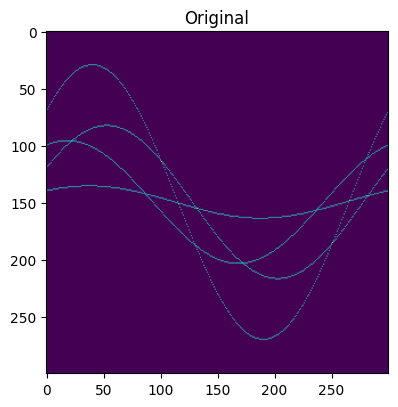

In [322]:
def sinuoids(x, y, arr, fiResolution, roResolution):
    for i in range(fiResolution):
        fi = i * 2 * np.pi / fiResolution - np.pi
        ro = x * np.cos(fi) + y * np.sin(fi)
        arr[i + int(ro + roResolution/2) * fiResolution] += 1
    return arr

fiResolution = 300
roResolution = 300
accumulator = np.zeros(fiResolution * roResolution)
accumulator = sinuoids(10, 10, accumulator, fiResolution, roResolution)
accumulator = sinuoids(30, 60, accumulator, fiResolution, roResolution)
accumulator = sinuoids(50, 20, accumulator, fiResolution, roResolution)
accumulator = sinuoids(80, 90, accumulator, fiResolution, roResolution)

f = plt.figure(figsize=(15, 8))
f.add_subplot(1, 3, 1)
plt.imshow(np.reshape(accumulator, (roResolution,fiResolution)))
plt.title("Original")
plt.show()

### b, c

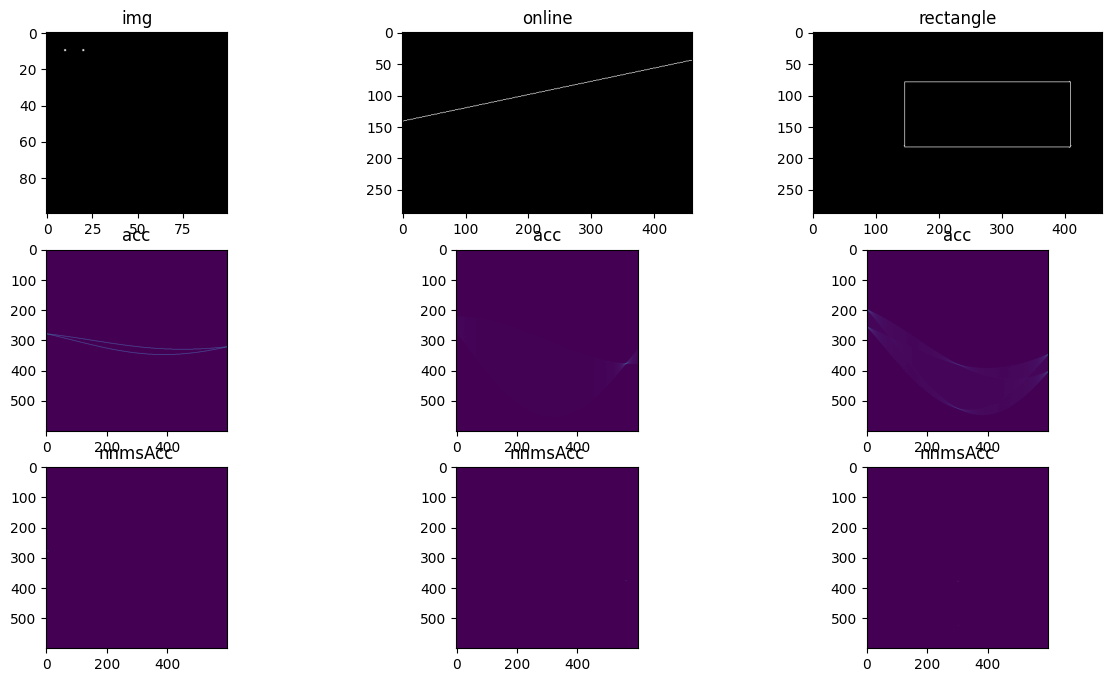

In [323]:
def accumulate(arr, x, y, width, height, fiResolution, roResolution):
    for i in range(fiResolution):
        fi = i * width / fiResolution - width / 2
        ro = (x * np.cos(fi) + y * np.sin(fi))
        j = int(np.round(ro / height * roResolution + roResolution/2))
        if j >= 0 and j < roResolution and ro >= -height/2 and ro < height/2:
            arr[i + j * fiResolution] += 1
    return arr

def nonmaxima_suppression_box(accumulator, w, h):
    arr = np.copy(accumulator)
    for y in range(h):
        for x in range(w):
            if arr[x + y * w] > 0 and x > 0 and x < w-1 and y > 0 and y < h-1:
                v = arr[x + y * w]
                if v <= arr[x+1 + y * w] or v <= arr[x-1 + y * w] or v <= arr[x + (y+1) * w] or v <= arr[x + (y-1) * w] or v <= arr[x+1 + (y+1) * w] or v <= arr[x-1 + (y-1) * w] or v <= arr[x-1 + (y+1) * w] or v <= arr[x+1 + (y-1) * w]:
                    arr[x + y * w] = 0
    return arr

def getFiRoParams(arr, w, threshold):
    arr[arr < threshold] = 0
    indexes = np.nonzero(arr)
    params = np.zeros((len(indexes[0]),3))
    params[:,0] = indexes[0] % w
    params[:,1] = np.floor_divide(indexes[0],w)
    params[:,2] = arr[indexes[0]]
    params = params[params[:, 2].argsort()]
    return params[::-1]

def hough_find_lines(img, fiResolution, roResolution, threshold):
    accumulator = np.zeros(fiResolution * roResolution)
    width = np.pi
    height = 2 * np.sqrt(np.sum(np.array(img.shape)**2))
    for y, row in enumerate(img):
        for x, pixel in enumerate(row):
            if pixel != 0:
                accumulator = accumulate(accumulator, x, y, width, height, fiResolution, roResolution)
             
    nnmsAcc = nonmaxima_suppression_box(accumulator, fiResolution, roResolution)
    fiRoParams = getFiRoParams(nnmsAcc, fiResolution, threshold)
    return accumulator, nnmsAcc, fiRoParams

fiResolution = 600
roResolution = 600
temp = np.zeros((100,100))
temp[10,10] = 1
temp[10,20] = 1
acc, nnmsAcc, fiRoParams = hough_find_lines(temp, fiResolution, roResolution, 2)

temp2 = cv2.imread('images/oneline.png') # 0-255
temp2 = cv2.cvtColor(temp2, cv2.COLOR_BGR2GRAY)
temp2 = temp2.astype(np.float64)
tempEdges2, tempEdgesThinned2 = findedges(temp2, 1, 40)
acc2, nnmsAcc2, fiRoParams2 = hough_find_lines(tempEdgesThinned2, fiResolution, roResolution, 200)

temp3 = cv2.imread('images/rectangle.png') # 0-255
temp3 = cv2.cvtColor(temp3, cv2.COLOR_BGR2GRAY)
temp3 = temp3.astype(np.float64)
tempEdges3, tempEdgesThinned3 = findedges(temp3, 1, 40)
acc3, nnmsAcc3, fiRoParams3 = hough_find_lines(tempEdgesThinned3, fiResolution, roResolution, 105)

f = plt.figure(figsize=(15, 8))
f.add_subplot(3, 3, 1)
plt.imshow(temp, cmap="gray")
plt.title("img")
f.add_subplot(3, 3, 4)
plt.imshow(np.reshape(acc, (roResolution,fiResolution)))
plt.title("acc")
f.add_subplot(3, 3, 7)
plt.imshow(np.reshape(nnmsAcc, (roResolution, fiResolution)))
plt.title("nnmsAcc")
f.add_subplot(3, 3, 2)
plt.imshow(tempEdgesThinned2, cmap="gray")
plt.title("online")
f.add_subplot(3, 3, 5)
plt.imshow(np.reshape(acc2, (roResolution,fiResolution)))
plt.title("acc")
f.add_subplot(3, 3, 8)
plt.imshow(np.reshape(nnmsAcc2, (roResolution, fiResolution)))
plt.title("nnmsAcc")
f.add_subplot(3, 3, 3)
plt.imshow(tempEdgesThinned3, cmap="gray")
plt.title("rectangle")
f.add_subplot(3, 3, 6)
plt.imshow(np.reshape(acc3, (roResolution,fiResolution)))
plt.title("acc")
f.add_subplot(3, 3, 9)
plt.imshow(np.reshape(nnmsAcc3, (roResolution, fiResolution)))
plt.title("nnmsAcc")
plt.show()

### d

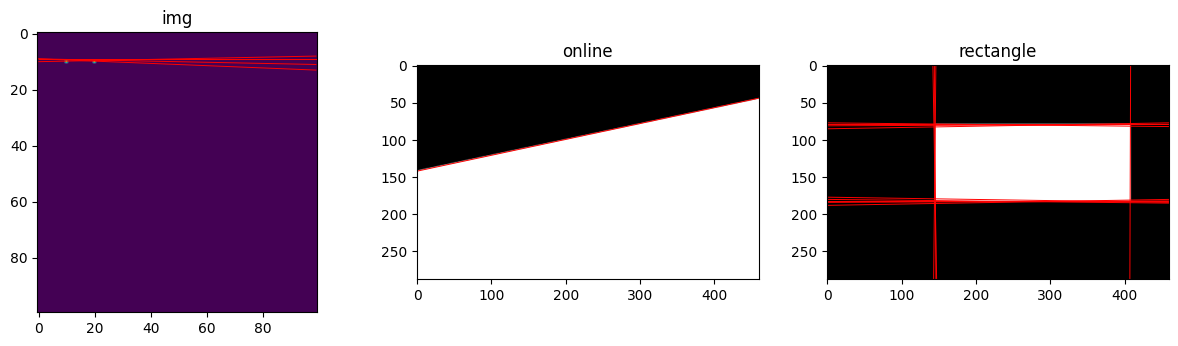

In [324]:
f = plt.figure(figsize=(15, 8))
f.add_subplot(2, 3, 1)
plt.imshow(temp)
for param in fiRoParams:
    draw_line(param[1] / roResolution * (np.sqrt(temp.shape[0]**2+temp.shape[1]**2)*2) - np.sqrt(temp.shape[0]**2+temp.shape[1]**2), param[0] / fiResolution * np.pi - np.pi/2, temp.shape[0], temp.shape[1])
plt.title("img")
f.add_subplot(2, 3, 2)
plt.imshow(temp2, cmap="gray")
for param in fiRoParams2:
    draw_line(param[1] / roResolution * (np.sqrt(temp2.shape[0]**2+temp2.shape[1]**2)*2) - np.sqrt(temp2.shape[0]**2+temp2.shape[1]**2), param[0] / fiResolution * np.pi - np.pi/2, temp2.shape[0], temp2.shape[1])
plt.title("online")
f.add_subplot(2, 3, 3)
plt.imshow(temp3, cmap="gray")
for param in fiRoParams3:
    draw_line(param[1] / roResolution * (np.sqrt(temp3.shape[0]**2+temp3.shape[1]**2)*2) - np.sqrt(temp3.shape[0]**2+temp3.shape[1]**2), param[0] / fiResolution * np.pi - np.pi/2, temp3.shape[0], temp3.shape[1])
plt.title("rectangle")
plt.show()

### e

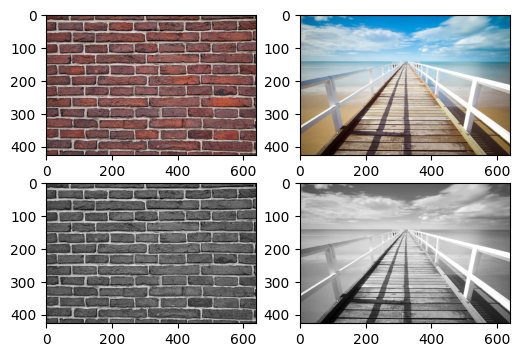

In [325]:
temp4 = cv2.imread('images/bricks.jpg') # 0-255
temp4rgb = cv2.cvtColor(temp4, cv2.COLOR_BGR2RGB)
temp4 = cv2.cvtColor(temp4, cv2.COLOR_BGR2GRAY)
temp4 = temp4.astype(np.float64)
temp5 = cv2.imread('images/pier.jpg') # 0-255
temp5rgb = cv2.cvtColor(temp5, cv2.COLOR_BGR2RGB)
temp5 = cv2.cvtColor(temp5, cv2.COLOR_BGR2GRAY)
temp5 = temp5.astype(np.float64)

f = plt.figure(figsize=(6, 4))
f.add_subplot(2, 2, 1)
plt.imshow(temp4rgb)
f.add_subplot(2, 2, 2)
plt.imshow(temp5rgb)
f.add_subplot(2, 2, 3)
plt.imshow(temp4, cmap="gray")
f.add_subplot(2, 2, 4)
plt.imshow(temp5, cmap="gray")
plt.show()

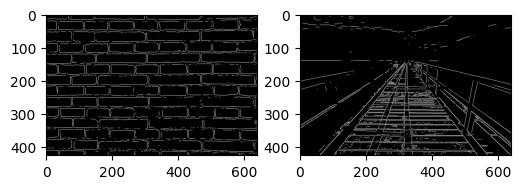

In [326]:
tempEdges4, tempEdgesThinned4 = findedges(temp4, 1, 50)
tempEdges5, tempEdgesThinned5 = findedges(temp5, 1, 20)
f = plt.figure(figsize=(6, 4))
f.add_subplot(1, 2, 1)
plt.imshow(tempEdgesThinned4, cmap="gray")
f.add_subplot(1, 2, 2)
plt.imshow(tempEdgesThinned5, cmap="gray")
plt.show()

In [327]:
fiResolution = 600
roResolution = 600
acc4, nnmsAcc4, fiRoParams4 = hough_find_lines(tempEdgesThinned4, fiResolution, roResolution, 100)
acc5, nnmsAcc5, fiRoParams5 = hough_find_lines(tempEdgesThinned5, fiResolution, roResolution, 200)

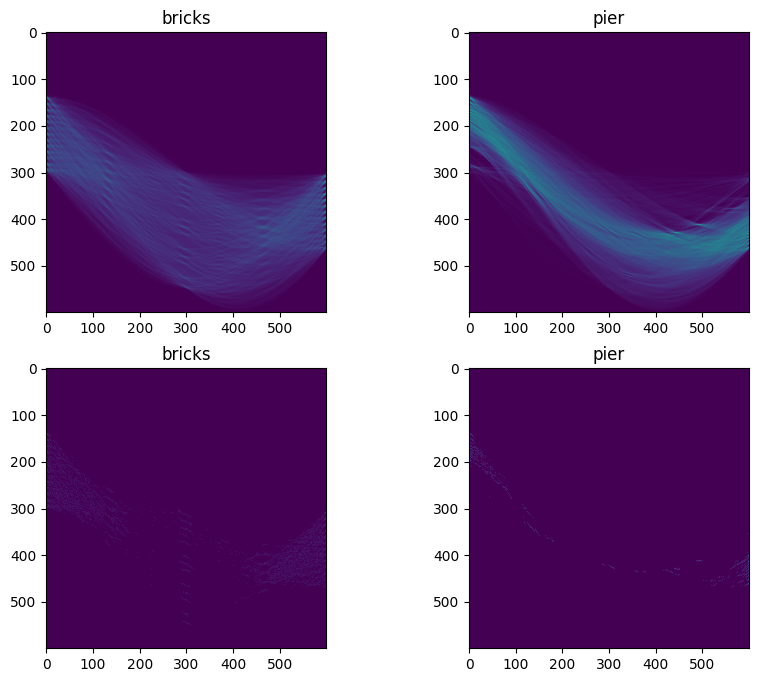

In [328]:
f = plt.figure(figsize=(10, 8))
f.add_subplot(2, 2, 1)
plt.imshow(np.reshape(acc4, (roResolution, fiResolution)))
plt.title("bricks")
f.add_subplot(2, 2, 2)
plt.imshow(np.reshape(acc5, (roResolution, fiResolution)))
plt.title("pier")
f.add_subplot(2, 2, 3)
plt.imshow(np.reshape(nnmsAcc4, (roResolution, fiResolution)))
plt.title("bricks")
f.add_subplot(2, 2, 4)
plt.imshow(np.reshape(nnmsAcc5, (roResolution, fiResolution)))
plt.title("pier")
plt.show()

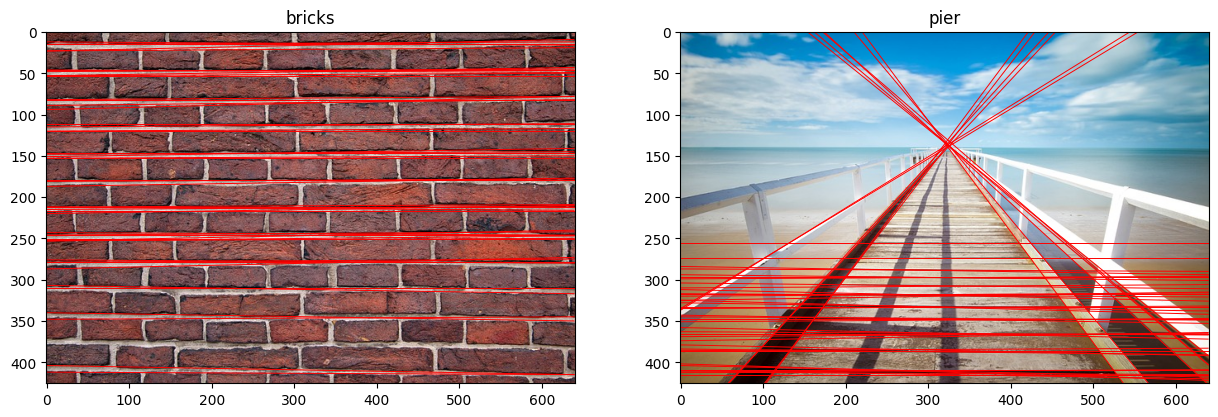

In [329]:
N = 50
f = plt.figure(figsize=(15, 8))
f.add_subplot(1, 2, 1)
plt.imshow(temp4rgb, cmap="gray")
for i, param in enumerate(fiRoParams4):
    if i > N-1:
        break;
    draw_line(param[1] / roResolution * (np.sqrt(tempEdgesThinned4.shape[0]**2+tempEdgesThinned4.shape[1]**2)*2) - np.sqrt(tempEdgesThinned4.shape[0]**2+tempEdgesThinned4.shape[1]**2), param[0] / fiResolution * np.pi - np.pi/2, tempEdgesThinned4.shape[0], tempEdgesThinned4.shape[1])
plt.title("bricks")
f.add_subplot(1, 2, 2)
plt.imshow(temp5rgb, cmap="gray")
for i, param in enumerate(fiRoParams5):
    if i > N-1:
        break;
    draw_line(param[1] / roResolution * (np.sqrt(tempEdgesThinned5.shape[0]**2+tempEdgesThinned5.shape[1]**2)*2) - np.sqrt(tempEdgesThinned5.shape[0]**2+tempEdgesThinned5.shape[1]**2), param[0] / fiResolution * np.pi - np.pi/2, tempEdgesThinned5.shape[0], tempEdgesThinned5.shape[1])
plt.title("pier")
plt.show()